# Speedtest-Analysis

Out of pure curiosity I installed the following crontab at my home a few months ago:
```cron
55 * * * * cd speedtest && speedtest-cli --csv >> speedtest-$(date -I).log
```

Today I got the chance to have a look at the data. The result is sobering.

If you find my use of pandas disgusting or want to tell me that I have no clue about statistics:
Please, tell me. I really don't know what I am doing. But I am willing to learn!

## Setup
Let's get started.

In [1]:
!pip3 install pandas matplotlib seaborn scipy > /dev/null

In [2]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy

plt.rcParams['figure.figsize'] = [20, 10]

### Read some files.

In [3]:
path = os.path.abspath("logs/")
files = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and "speedtest-" in f]

### Read the headers
They were generated by 
```bash
speedtest-cli --csv-headers > header.csv
```

In [4]:
header = pd.read_csv("header.csv")
headers = header.columns.values

### Read all the CSV files

Now, we read all the CSV files we generated, and manipulate the columns somewhat.

In [5]:
dfs = [pd.read_csv(file, names=headers, parse_dates=['Timestamp']) for file in files]

df = pd.concat(dfs, ignore_index=True)

Download and Upload speed are given in Bits/second. We want to calculate everything in MBits/second, because.

Additionally, we're also going to add columns for 
- the week number
- the date, rounded to the day
- the hour of the day

In [6]:
df['Download'] = df['Download'] / 1000_000
df['Upload'] = df['Upload'] / 1000_000

df['week'] = df['Timestamp'].dt.isocalendar().week
df['day'] = df['Timestamp'].dt.round('D')
df['hour'] = df['Timestamp'].dt.hour

# Let's see our data.
df

,Server ID,Sponsor,Server Name,Timestamp,Distance,Ping,Download,Upload,Share,IP Address,week,day,hour
0,35707,Omikrongaming,Scheden,2020-09-11 22:55:01.682606+00:00,24.224304,32.923,155.839329,15.233743,NaN,84.118.123.46,37,2020-09-12 00:00:00+00:00,22
1,35707,Omikrongaming,Scheden,2020-09-11 23:55:01.852572+00:00,24.224304,29.044,112.072100,15.308749,NaN,84.118.123.46,37,2020-09-12 00:00:00+00:00,23
2,26485,GameAddicted,Lauterbach,2020-09-12 00:55:01.948114+00:00,75.790777,29.533,137.374943,15.135505,NaN,84.118.123.46,37,2020-09-12 00:00:00+00:00,0
3,35707,Omikrongaming,Scheden,2020-09-12 01:55:02.203857+00:00,24.224304,29.849,102.063145,15.253193,NaN,84.118.123.46,37,2020-09-12 00:00:00+00:00,1
4,35707,Omikrongaming,Scheden,2020-09-12 02:55:01.903670+00:00,24.224304,28.654,126.892212,15.282557,NaN,84.118.123.46,37,2020-09-12 00:00:00+00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,1570,Sigmasoft,Lutin,2020-09-23 17:55:01.914491+00:00,576.508024,37.727,71.950139,15.035654,NaN,84.118.123.46,39,2020-09-24 00:00:00+00:00,17
1766,35707,Omikrongaming,Scheden,2020-09-23 18:55:02.169712+00:00,26.063617,33.377,85.812283,14.977572,NaN,84.118.123.46,39,2020-09-24 00:00:00+00:00,18
1767,26485,GameAddicted,Lauterbach,2020-09-23 19:55:01.787472+00:00,72.777481,31.548,83.949344,15.091375,NaN,84.118.123.46,39,2020-09-24 00:00:00+00:00,19
1768,35707,Omikrongaming,Scheden,2020-09-23 20:55:02.015487+00:00,26.063617,35.042,85.409244,14.895764,NaN,84.118.123.46,39,2020-09-24 00:00:00+00:00,20


Okay, so we have a lot of data. 
- We have one datum per hour. 
- Each measurement contains a ping, upload and download bandwidth in MBit/s
- Whatever "Share" is, I don't know.
- We also get the sponsor for the server, their server name, and my distance to the server in km.

Let's get some statistics!

In [7]:
df[['Distance', 'Ping', 'Download', 'Upload']].describe()

,Distance,Ping,Download,Upload
count,1770.000000,1770.000000,1770.000000,1770.000000
mean,100.029460,31.867914,136.710643,14.927040
std,79.069941,2.694612,44.076867,0.736564
min,21.465978,24.138000,13.436176,5.583870
25%,26.063617,30.286000,87.926500,14.935247
50%,78.375288,31.443000,151.862055,15.105018
75%,133.185673,33.007500,174.798485,15.206465
max,632.841715,86.565000,210.715035,15.415738


Some takeaways from this:

- I have 1768 measurements.
- the average upload speed is 15 MBit/s
   - pretty good, considering the max is 15.4 -- we only have a deviation of .7!
- the average download speed is 137 MBit/s 
   - not as good....
   

## Graphs

Let's make some pretty graphics.
First, I'm interested in the speed over time.

<AxesSubplot:xlabel='day', ylabel='Download'>

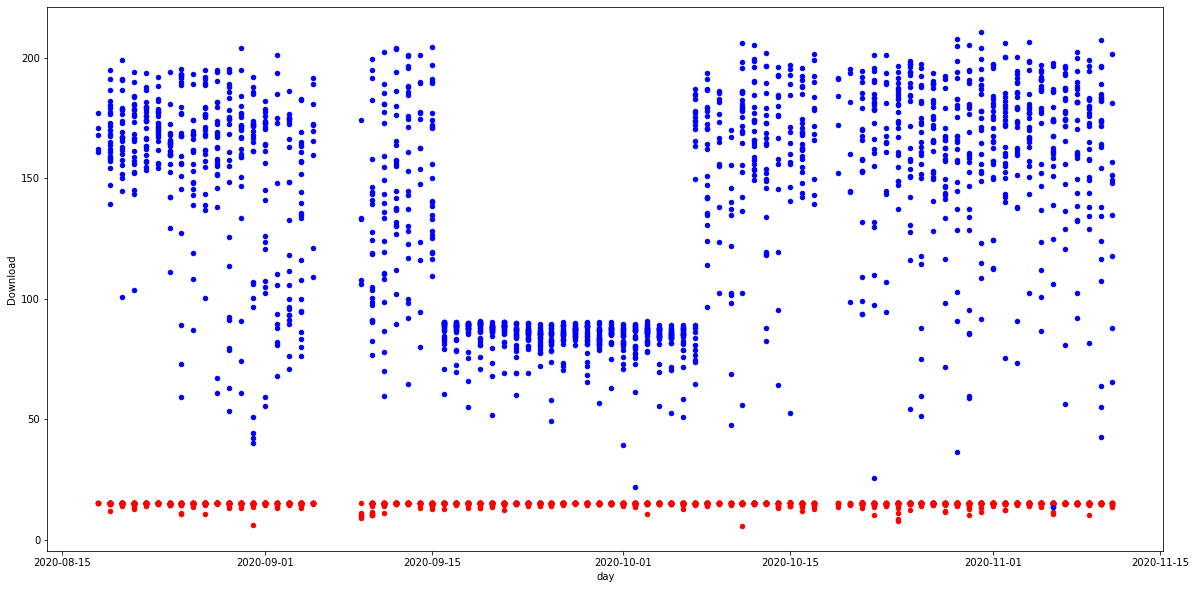

In [8]:
ax = df.plot.scatter(y='Upload', x='day', color="Red")
df.plot.scatter(y='Download', x='day', color="Blue", ax=ax)

Oops, looks like I used a 100 Mbit port for a while there. No problem, we can filter out that data.

Otherwise, I don't see any obvious patterns. The upload speed is pretty pegged at the top of it's range, so it is probably artificially limited somewhere. The download speed looks like a normal distribution centered around 150 MBit/s.


In [9]:
# Delete bad data
from datetime import datetime
start_delete = datetime.strptime("2020-09-15", "%Y-%m-%d").date()
end_delete = datetime.strptime("2020-10-06", "%Y-%m-%d").date()
filtered = df[(df['Timestamp'].dt.date < start_delete) | (df['Timestamp'].dt.date > end_delete)]

# Also regenerate our statistics with this cleaned-up data.

filtered[['Distance', 'Ping', 'Download', 'Upload']].describe()

,Distance,Ping,Download,Upload
count,1249.000000,1249.000000,1249.000000,1249.000000
mean,102.492318,31.813666,157.966474,14.889837
std,77.985466,2.844464,33.521853,0.835272
min,21.465978,24.138000,13.436176,5.583870
25%,26.063617,30.245000,145.469547,14.926550
50%,108.075921,31.406000,166.585283,15.102583
75%,134.344645,32.919000,180.654661,15.203793
max,593.706611,86.565000,210.715035,15.415738


That looks a bit better. Our deviation went down somewhat.

Let's get an overview of our Download and Upload rates. Plotting these against each other will also let us see if there's any correlation.

<AxesSubplot:xlabel='Download', ylabel='Upload'>

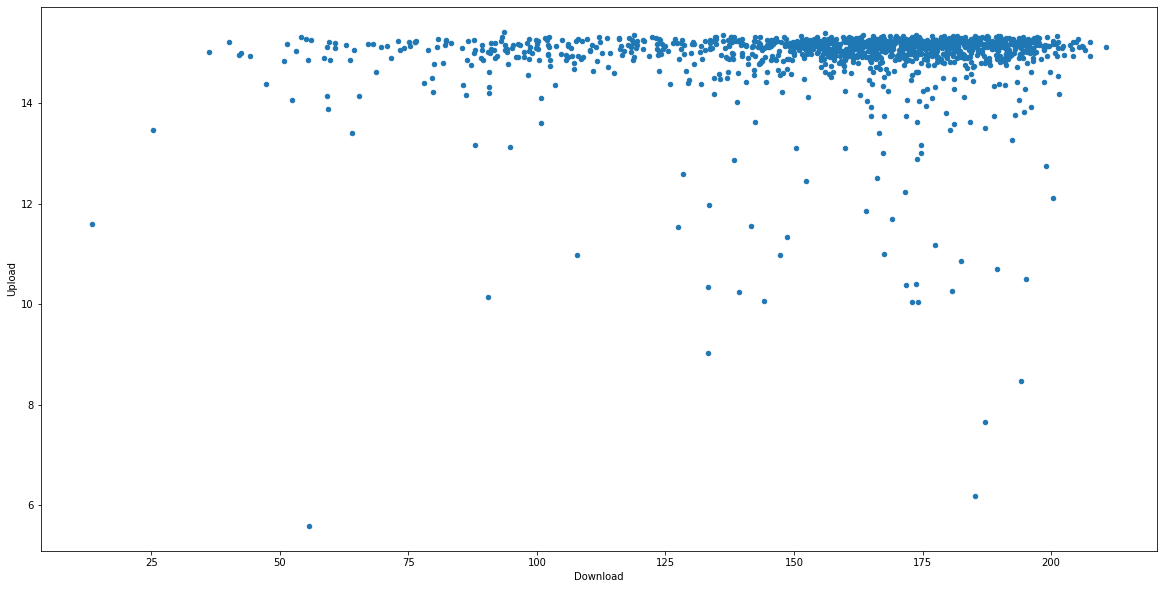

In [10]:
filtered.plot.scatter(x='Download', y='Upload')

We can see from this that low download does not seem to have any correlation to low upload speeds... Also, we see again that upload speed is much more stable than download speed.

## Correlations

Let's get a rough overview of correlations.

In [11]:
df_corr = filtered[['Distance', 'Ping', 'Download', 'Upload', 'week', 'hour']]
correlations = df_corr.corr()
correlations = correlations[(correlations.abs() > .1) & (correlations.abs() != 1)]
correlations

,Distance,Ping,Download,Upload,week,hour
Distance,NaN,0.196322,-0.189301,NaN,NaN,NaN
Ping,0.196322,NaN,-0.204673,-0.123774,NaN,0.178009
Download,-0.189301,-0.204673,NaN,NaN,NaN,NaN
Upload,NaN,-0.123774,NaN,NaN,NaN,NaN
week,NaN,NaN,NaN,NaN,NaN,NaN
hour,NaN,0.178009,NaN,NaN,NaN,NaN


Argh, I can't see anything! I need some colors!

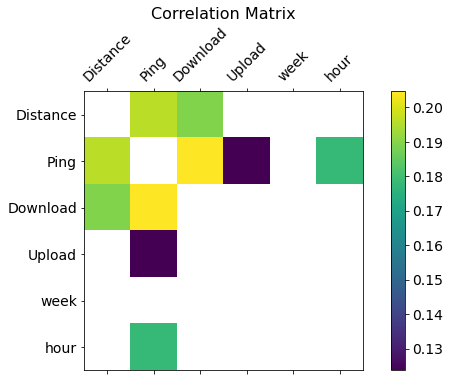

In [12]:
#fig, ax = plt.subplots() #(figsize = (20,4))

f = plt.figure(figsize=(10, 5))
plt.matshow(correlations.abs(), fignum=f.number)
plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Well, okay. We have almost no correlations anywhere.
We can see:
- ping and download speed correlate the most. Not by much, but let's look at it in detail later.
- ping and distance correlate a bit. That makes sense. Speed of signal in wire etc. 

Interestingly, we see a small one between 

## Correlation of Ping and Distance

In [13]:
milliseconds_for_500km = 500*1000 / scipy.constants.c * 1000
milliseconds_for_500km_roundtrip = milliseconds_for_500km * 2
milliseconds_for_500km_roundtrip

3.3356409519815204

[(0.0, 400.0)]

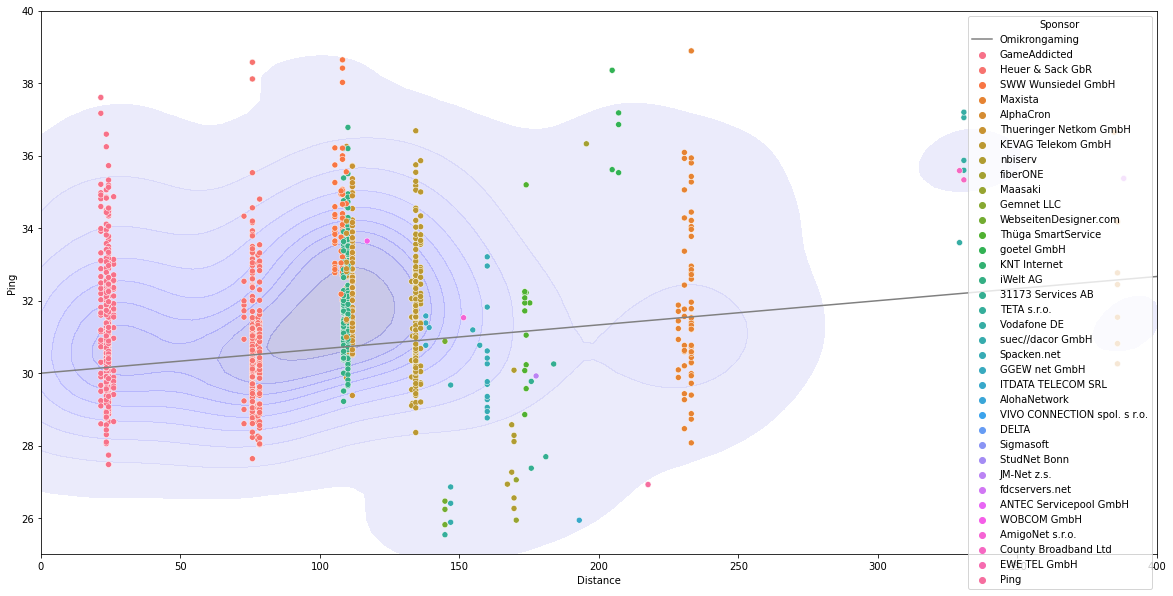

In [14]:
# a KDE-Plot so we can see rough groupings
ax = sns.kdeplot(data=filtered, x='Distance', y='Ping', color='#ddf', alpha=.3, fill=True)

# add in a scatterplot, colored by the sponsor
sns.scatterplot(data=filtered, x='Distance', y='Ping', ax=ax, hue='Sponsor')

# add  a line that indicates light speed
pd.DataFrame({'Distance': [0, 500], 'Ping': [30, 30 + milliseconds_for_500km_roundtrip]})\
    .plot.line(x='Distance', y='Ping', ax=ax, color='grey')

# don't plot the outliers
ax.set(ylim = (25, 40))
ax.set(xlim = (0, 400))

Note that the grey line is *not* a regression or anything actually statistically significant. Instead, it shows the line (starting at 30ms ping) that would be expected from lightspeed. We do see a slight upwards tendence which might be explained by the distance, but it we don't have a lot of data to support that.

Sidenote: Have you read the [case of the 500-mile email][500]?

[500]: https://www.ibiblio.org/harris/500milemail.html

## Time of day

I was curious to see whether the time of day affected the speeds at all. Let's do the same thing as in the first plot, but use the hour-of-day instead of the datetime.

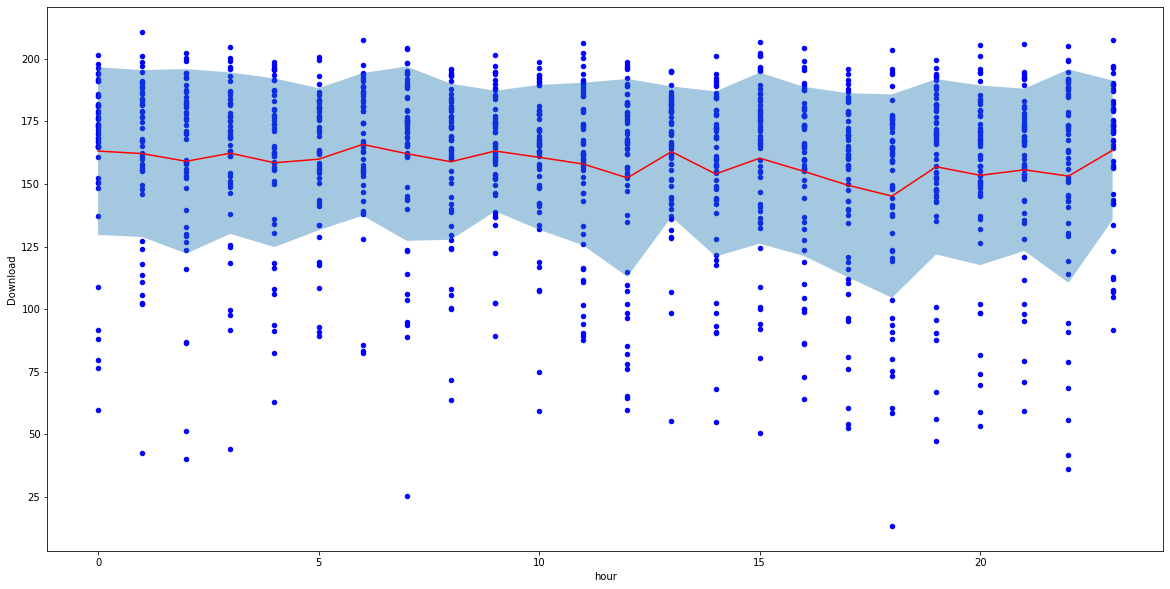

In [15]:
ax = filtered.plot.scatter(y='Download', x='hour', color="Blue")

# calculate the mean value for each hour
grouped = filtered.groupby('hour')
mean = grouped.mean()['Download']
std = grouped.std()['Download']
mean.plot(ax=ax, color='red')
plt.fill_between(range(len(mean)), mean + std, mean - std, alpha=.4)


Well... As the "correlations" part already told us, there's nothing significant between time of day and speeds. We do see a sliiiiight decrease in download speeds in the evening.

Maybe for Pings?

[(-1.0, 24.0)]

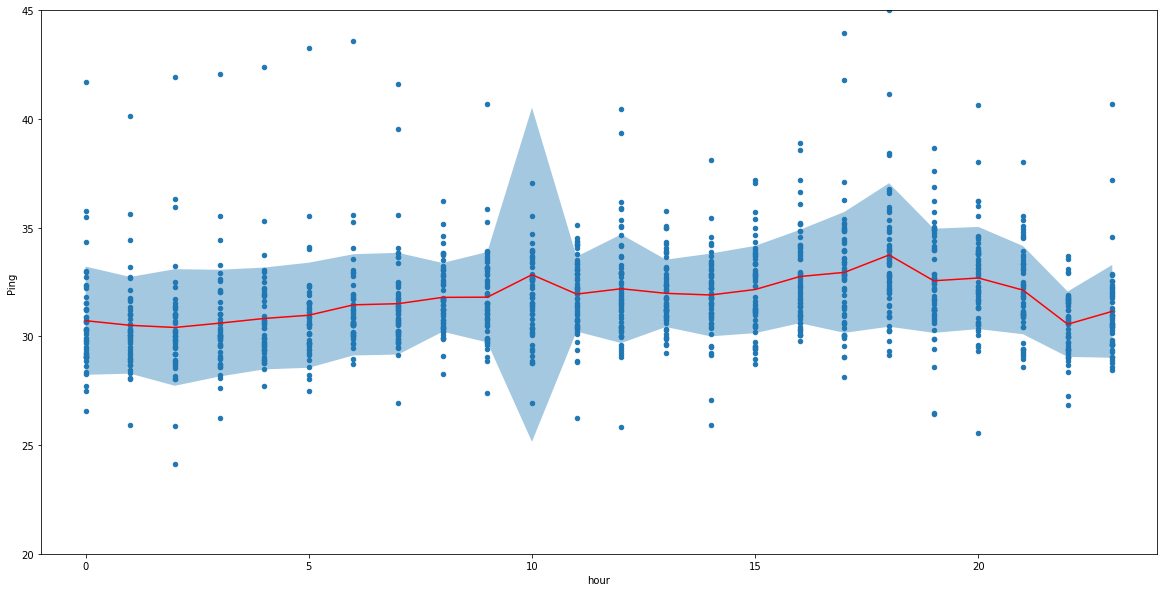

In [16]:
ax = filtered.plot.scatter(y='Ping', x='hour')

# calculate the mean value for each hour
grouped = filtered.groupby('hour')
mean = grouped.mean()['Ping']
std = grouped.std()['Ping']
mean.plot(ax=ax, color='red')
plt.fill_between(range(len(mean)), mean + std, mean - std, alpha=.4)

ax.set(ylim=(20, 45))
ax.set(xlim=(-1, 24))

The blue background is the mean +/- the standard deviation for the ping values.

We can see that the Ping is slightly higher in the afternoon hours. It peaks at 6 pm. However, the difference is 3ms at best.
We have some outliers at 10:00.

## Conclusion

The only things I learned are:
- I'm very new to data science.
- My download speed does not correlate with time of day.
- My upload speed is 15Mbit/s, instead of the advertised 20. Blergh!

Thanks for reading!

## Acknowledgements

Thanks for all the visualization help to the folks at [flipdot][fd]!

[fd]: https://flipdot.org